# PeMS_data

In [ ]:
!pip install lightgbm

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [1]:
import pandas as pd
import numpy as np

In [ ]:
PeMS_data = pd.read_pickle('PeMS_dataset.pkl')
PeMS_data.sort_values('TOD')

,Date,TOD,Travel Time,# Lane Pts,start,end,distance
0,2020-01-10,00:00,3.38,37,SR 78,Centre City Pkwy,6.28
209369,2020-06-29,00:00,16.42,144,405-N/Sepulveda Blvd,405-N/Onion Ave,30.58
186047,2020-06-12,00:00,16.47,144,405-N/Sepulveda Blvd,405-N/Onion Ave,30.58
195554,2020-06-19,00:00,3.38,37,SR 78,Centre City Pkwy,6.28
195547,2020-06-19,00:00,16.58,144,405-N/Sepulveda Blvd,405-N/Onion Ave,30.58
...,...,...,...,...,...,...,...
183545,2020-06-11,23:55,19.70,231,405-N/Wardlow Rd,405-N/National Blvd,35.89
13049,2020-01-22,23:55,19.57,232,405-N/Wardlow Rd,405-N/National Blvd,35.89
47060,2020-02-21,23:55,16.77,144,405-N/Sepulveda Blvd,405-N/Onion Ave,30.58
43009,2020-02-18,23:55,21.15,248,405-N/Wardlow Rd,405-N/State Hwy 2,39.12


In [ ]:
PeMS_data.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Travel Time,211392.0,30.062288,23.704173,3.05,18.13,23.07,40.10,163.37
# Lane Pts,211392.0,260.333428,179.409164,24.00,144.00,249.00,320.00,1139.00
distance,211392.0,45.888828,35.494263,6.28,30.58,39.12,58.74,215.97


In [ ]:
from sklearn.preprocessing import LabelEncoder

def data_preprocessing(data):

    labelencoder = LabelEncoder()

    data['LanePts'] = labelencoder.fit_transform(data['# Lane Pts'])
    data['start'] = labelencoder.fit_transform(data['start'])
    data['end'] = labelencoder.fit_transform(data['end'])

    data['Timestamp'] = data['Date'].dt.strftime('%Y-%m-%d').astype('str') +' '+ data['TOD'].astype('str')
    data['Timestamp'] = data['Timestamp'].astype(np.datetime64)

    data = data.sort_values('Timestamp').reset_index(drop=True)

    data['dept_hour'] = data['Timestamp'].dt.hour
    data['dept_minute'] = data['Timestamp'].dt.minute
    data['dept_dayofweek'] = data['Timestamp'].dt.dayofweek
    data['dept_monthofyear'] = data['Timestamp'].dt.month 

    data = data.drop(['Date','TOD','Timestamp','# Lane Pts'],1)
    
    return data

In [ ]:
data = data_preprocessing(PeMS_data)

In [ ]:
data

,Travel Time,start,end,distance,LanePts,dept_hour,dept_minute,dept_dayofweek,dept_monthofyear
0,3.38,5,5,6.28,3,0,0,4,1
1,42.95,4,6,77.90,199,0,0,4,1
2,20.00,2,2,35.89,77,0,0,4,1
3,16.48,1,3,30.58,23,0,0,4,1
4,21.83,2,4,39.12,95,0,0,4,1
...,...,...,...,...,...,...,...,...,...
211387,16.48,1,3,30.58,24,23,55,1,6
211388,19.82,2,2,35.89,78,23,55,1,6
211389,3.37,5,5,6.28,3,23,55,1,6
211390,42.82,4,6,77.90,201,23,55,1,6


In [ ]:
train_data = data[data.dept_monthofyear < 6]
test_data = data[data.dept_monthofyear == 6]

In [ ]:
train_x, train_y = train_data.drop(['Travel Time'],1), train_data['Travel Time']

In [2]:
import pickle

with open('PeMS_data/train_x.pkl','rb') as f:
    train_x = pickle.load(f)

with open('PeMS_data/train_y.pkl','rb') as f:
    train_y = pickle.load(f)

with open('PeMS_data/test_x.pkl','rb') as f:
    test_x = pickle.load(f)

with open('PeMS_data/test_y.pkl','rb') as f:
    test_y = pickle.load(f)

C:\Users\irfan\anaconda3\envs\tensorflow\lib\site-packages\numpy\_distributor_init.py:32: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\irfan\anaconda3\envs\tensorflow\lib\site-packages\numpy\.libs\libopenblas.NOIJJG62EMASZI6NYURL6JBKM4EVBGM7.gfortran-win_amd64.dll
C:\Users\irfan\anaconda3\envs\tensorflow\lib\site-packages\numpy\.libs\libopenblas.WCDJNK7YVMPZQ2ME2ZZHJJRJ3JIKNDB7.gfortran-win_amd64.dll
  stacklevel=1)


In [3]:
import pandas as pd
import numpy as np
import lightgbm as lgb
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV

# Create the parameter grid: gbm_param_grid
hyper_params = {
    'learning_rate': [0.001, 0.01, 0.02, 0.1, 0.2, 0.3, 0.4, 0.5],
    'bagging_freq': [5,10,15],
    'n_estimators': [300,400,500,800,1000],
    'max_depth': range(4, 12)
}

# Instantiate the regressor: gbm
gbm = lgb.LGBMRegressor()

# Perform grid search: grid_mse
grid_mse = GridSearchCV(param_grid=hyper_params, estimator=gbm, 
                        scoring='neg_mean_squared_error', cv=2, verbose=1)

# Fit grid_mse to the data
grid_mse.fit(train_x, train_y)

# Print the best parameters and lowest RMSE
print("Best parameters found: ", grid_mse.best_params_)
print("Lowest RMSE found: ", np.sqrt(np.abs(grid_mse.best_score_)))

Fitting 2 folds for each of 960 candidates, totalling 1920 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1920 out of 1920 | elapsed: 88.7min finished


Best parameters found:  {'bagging_freq': 5, 'learning_rate': 0.1, 'max_depth': 9, 'n_estimators': 1000}
Lowest RMSE found:  0.6590152476383977


In [ ]:
# Print the best parameters and lowest RMSE
print("Best parameters found: ", grid_mse.best_params_)
print("Lowest RMSE found: ", np.sqrt(np.abs(grid_mse.best_score_)))

In [4]:


#Fitting lgb regressor 
model = lgb.LGBMRegressor(objective= 'regression', eval_metric= 'rmse',
                         bagging_freq= 5, learning_rate= 0.1, max_depth= 9, n_estimators= 1000)
model.fit(train_x,train_y)
print (model)

LGBMRegressor(bagging_freq=5, eval_metric='rmse', max_depth=9,
              n_estimators=1000, objective='regression')


In [5]:
import pickle

file_name = "lgb_reg_PeMS.pkl"

# save
pickle.dump(model, open(file_name, "wb"))

# load
lgb_model_loaded = pickle.load(open(file_name, "rb"))

In [ ]:
test_x, test_y = test_data.drop(['Travel Time'],1), test_data['Travel Time']

In [ ]:
test_x

,start,end,distance,LanePts,dept_hour,dept_minute,dept_dayofweek,dept_monthofyear
167904,4,6,77.90,202,0,0,0,6
167905,5,5,6.28,3,0,0,0,6
167906,2,2,35.89,77,0,0,0,6
167907,0,1,58.74,144,0,0,0,6
167908,1,3,30.58,24,0,0,0,6
...,...,...,...,...,...,...,...,...
211387,1,3,30.58,24,23,55,1,6
211388,2,2,35.89,78,23,55,1,6
211389,5,5,6.28,3,23,55,1,6
211390,4,6,77.90,201,23,55,1,6


In [6]:
# Evaluate Model

from sklearn.metrics import mean_absolute_error, r2_score
import math

def evaluate(model, test_features, test_labels):
    predictions = model.predict(test_features)
    mae = mean_absolute_error(test_labels, predictions)
    errors = abs(predictions - test_labels)
    mape = 100 * np.mean(np.abs(errors / test_labels))
    accuracy = 100 - mape
    MSE = np.square(np.subtract(test_labels,predictions)).mean() 
    RMSE = math.sqrt(MSE)
    R2 = r2_score(test_labels,predictions)
    print('Model Performance')
    print('MAE: {:0.4f} minutes.'.format(np.mean(errors)))
    print('RMSE: {:0.2f}.'.format(RMSE))
    print('R2: {:0.2f}.'.format(R2))
    print('Accuracy = {:0.2f}%.'.format(accuracy))
    
    return accuracy

In [7]:
evaluate(lgb_model_loaded, test_x, test_y)

Model Performance
MAE: 0.4085 minutes.
RMSE: 0.64.
R2: 1.00.
Accuracy = 98.42%.


98.41576496936439

In [ ]:
predictions = lgb_model_loaded.predict(test_x)

In [ ]:
pre_ac = pd.DataFrame()

pre_ac['Actual'] = test_y
pre_ac['Prediction'] = predictions
pre_ac['dayofweek'] = test_x['dept_dayofweek']
pre_ac['travels'] = [l for l in range(0,len(predictions))]

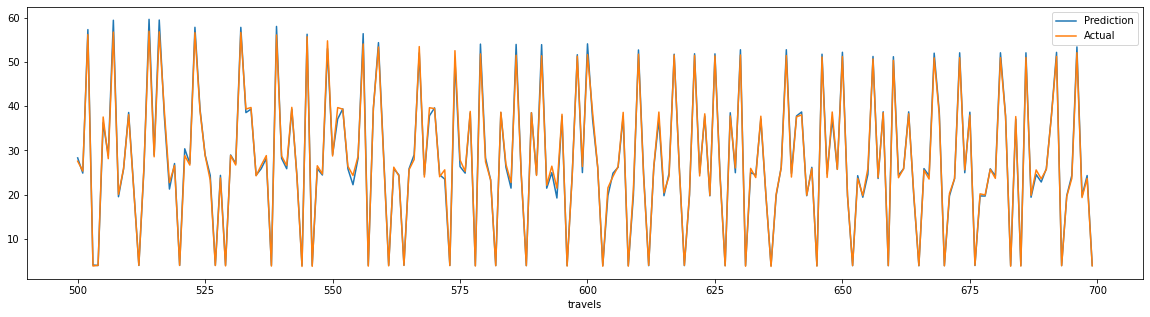

In [ ]:
import matplotlib.pyplot as plt

##### plot according to time of day

pre_ac[500:700].plot(x= "travels" , y=['Prediction', 'Actual'])
plt.rcParams["figure.figsize"] = (20,5)
plt.show()

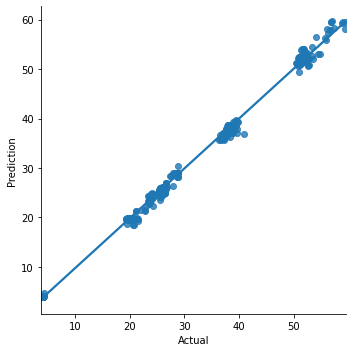

In [ ]:
import seaborn as sns

sns.lmplot(x="Actual", y="Prediction", data=pre_ac[500:1000]);

In [ ]:
import shap
 
# load JS visualization code to notebook
shap.initjs()

# explain the model's predictions using SHAP
# (same syntax works for LightGBM, CatBoost, scikit-learn, transformers, Spark, etc.)
explainer = shap.TreeExplainer(lgb_model_loaded)
shap_values = explainer.shap_values(test_x)

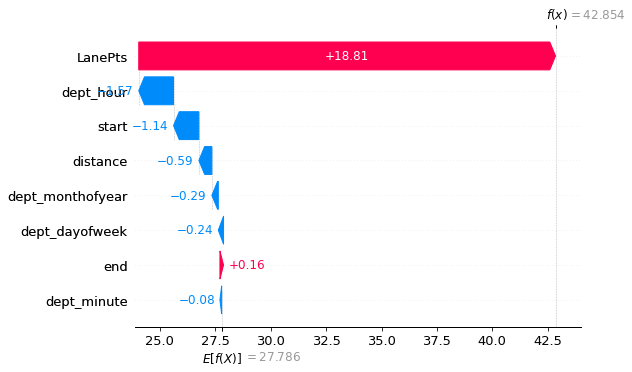

In [ ]:
'''The explanation below shows features each contributing to push the model output from the base value 
(the average model output over the training dataset we passed) to the model output. Features pushing the 
prediction higher are shown in red, those pushing the prediction lower are in blue.'''


shap.plots._waterfall.waterfall_legacy(explainer.expected_value, shap_values[0], feature_names = test_x.columns, show = True)

In [ ]:
# visualize the first prediction's explanation with a force plot
shap.force_plot(explainer.expected_value, shap_values[0], feature_names = test_x.columns, show = True)

In [ ]:
shap.force_plot(explainer.expected_value, shap_values[0:1000], feature_names = test_x.columns, show = True)

In [ ]:
# !pip install lime

In [ ]:
import lime
import lime.lime_tabular

In [ ]:
explainer = lime.lime_tabular.LimeTabularExplainer(train_x, feature_names=test_x.columns, class_names=['Travel Time'], verbose=True, mode='regression')

TypeError: '(slice(None, None, None), 0)' is an invalid key